In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
mpl.rc('figure', figsize = (15,15))
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
import pandas as pd
import numpy as np
import os

DATA_DIR = "data"
salt = 'hackathon-three-cities_'
l1_nrows = 1512
l2_nrows = 1248
n_horizons = 4
y_height = 3001

# Загружаем значения высот в узлах сетки для срезов L1 и L2

all_data_l1 = np.load(os.path.join(DATA_DIR, salt+"all_data_L1.npy"))
all_data_l2 = np.load(os.path.join(DATA_DIR, salt+"all_data_L2.npy"))

assert all_data_l1.shape == (l1_nrows, y_height), "Неправильный размер all_data_L1.npy"
assert all_data_l2.shape == (l2_nrows, y_height), "Неправильный размер all_data_L2.npy"

# Загружаем горизонты

l1_horizons_train = pd.read_csv(os.path.join(DATA_DIR, salt+"L1_horizons_train.csv"))
l2_horizons_train = pd.read_csv(os.path.join(DATA_DIR, salt+"L2_horizons_train.csv"))

assert l1_horizons_train.shape == (l1_nrows, n_horizons+1)
assert l2_horizons_train.shape == (l2_nrows, n_horizons+1)

sample_submission = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))
my_submission = sample_submission.copy()

In [4]:
all_data_l1 -= all_data_l1.min()

In [5]:
def plot_heights(df, data, key = 'hor_1'):
    tmp = df[df[key].notna()].copy()
    tmp[key] = tmp[key].values.astype(int)
    sl_x = tmp.x.values
    sl_y = tmp[key].astype(int)
    plt.figure(figsize=(15,2))
    plt.plot(np.log(data.T[sl_x, sl_y]))
    return sl_x, sl_y

(array([  59,   60,   61, ..., 1450, 1451, 1452]),
 59      710
 60      710
 61      710
 62      710
 63      710
        ... 
 1448    714
 1449    714
 1450    714
 1451    714
 1452    714
 Name: hor_1, Length: 1394, dtype: int64)

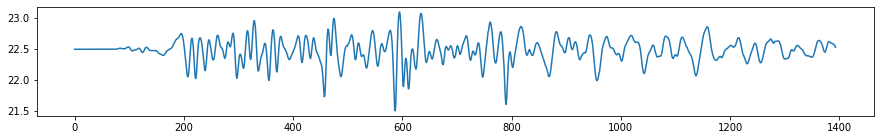

In [6]:
plot_heights(l1_horizons_train, all_data_l1, key='hor_1')

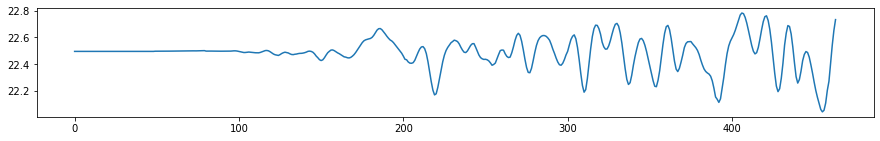

In [7]:
x,y = plot_heights(l1_horizons_train, all_data_l1, key='hor_2')

(array([  58,   59,   60, ..., 1449, 1450, 1451]),
 58      854
 59      855
 60      855
 61      856
 62      856
        ... 
 1447    867
 1448    867
 1449    867
 1450    867
 1451    867
 Name: hor_3, Length: 1394, dtype: int64)

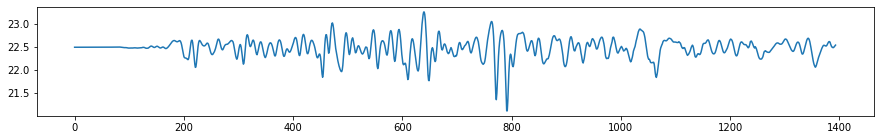

In [8]:
plot_heights(l1_horizons_train, all_data_l1, key='hor_3')

(array([  58,   59,   60, ..., 1449, 1450, 1451]),
 58      984
 59      984
 60      984
 61      984
 62      984
        ... 
 1447    984
 1448    984
 1449    984
 1450    985
 1451    985
 Name: hor_4, Length: 1394, dtype: int64)

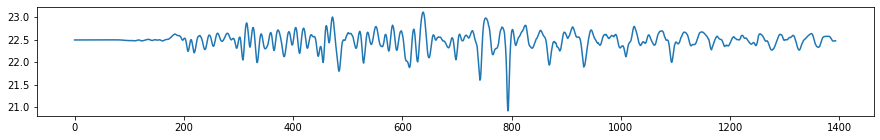

In [9]:
plot_heights(l1_horizons_train, all_data_l1, key='hor_4')

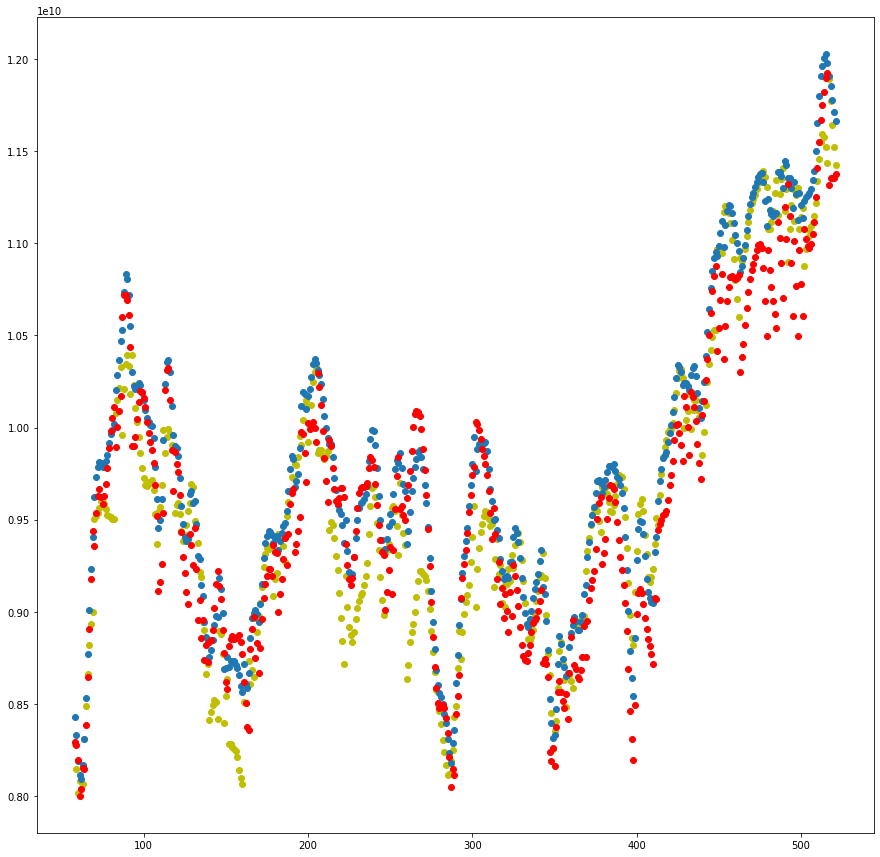

In [10]:
plt.scatter(x, all_data_l1[x,y-1], color='y')
plt.scatter(x, all_data_l1[x,y])
plt.scatter(x, all_data_l1[x,y+1], color='red')

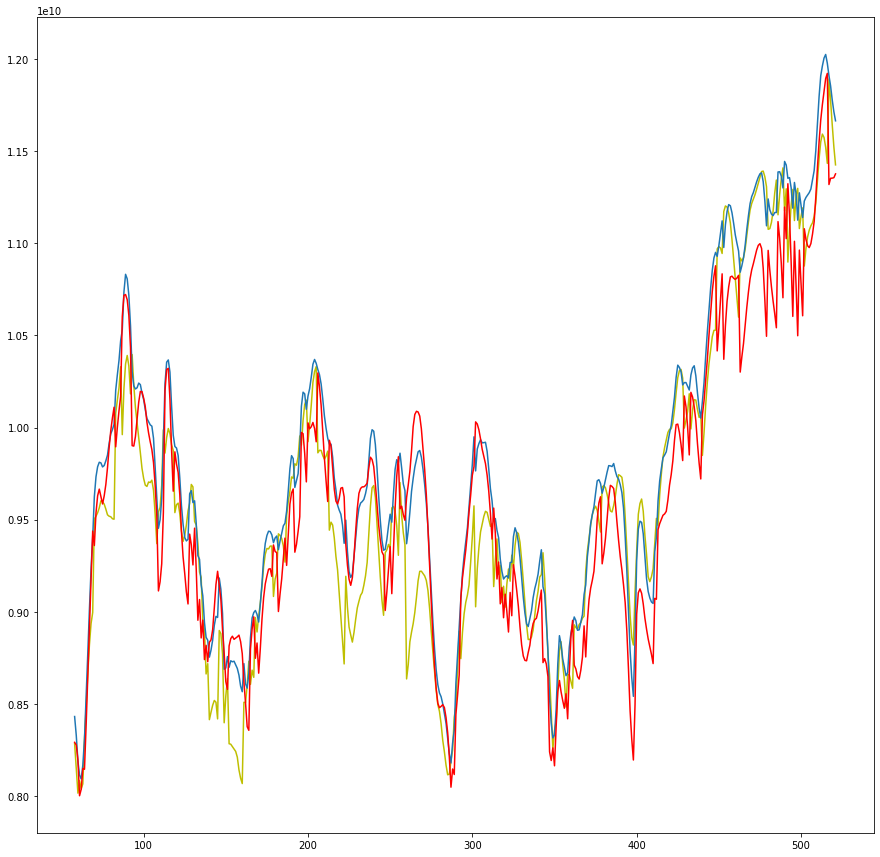

In [11]:
plt.plot(x, all_data_l1[x,y-1], color='y')
plt.plot(x, all_data_l1[x,y])
plt.plot(x, all_data_l1[x,y+1], color='red')

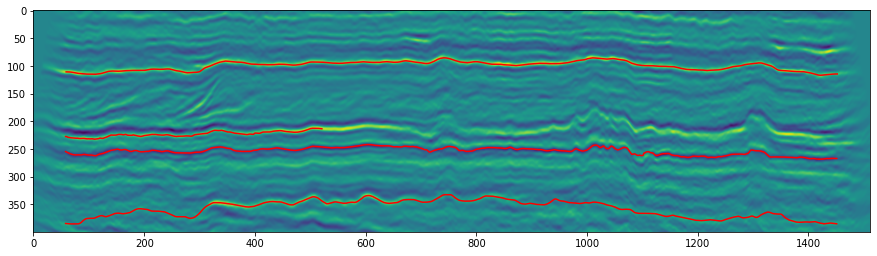

In [15]:
plt.imshow(all_data_l1.T[600:1000])
plt.plot(l1_horizons_train.hor_1-600, color='red')
plt.plot(l1_horizons_train.hor_2-600, color='red')
# plt.plot(y_hat-600, color='black')
plt.plot(l1_horizons_train.hor_3-600, color='red')
plt.plot(l1_horizons_train.hor_4-600, color='red')

In [31]:
start_idx = 522 #my_submission.x.min()
end_idx = 1451 #my_submission.x.max()

tmp = l1_horizons_train.loc[start_idx:end_idx].copy()
y_hat = np.zeros_like(tmp.x.values)

y_prev = l1_horizons_train.loc[start_idx-1, 'hor_2']
y_prev = int(y_prev)
print(y_prev)
print(len(y_hat))

N_neighbours = 21
for i, x in enumerate(tmp.x):
    mid_point = N_neighbours // 2
    neighbours = np.array([all_data_l1.T[y_prev+j, x] for j in range(-mid_point, mid_point + 1)])
    
    assert N_neighbours == len(neighbours)
                          
    upd = np.argmax(neighbours)
    y_prev += (upd - mid_point)
    y_hat[i] = y_prev

813
930


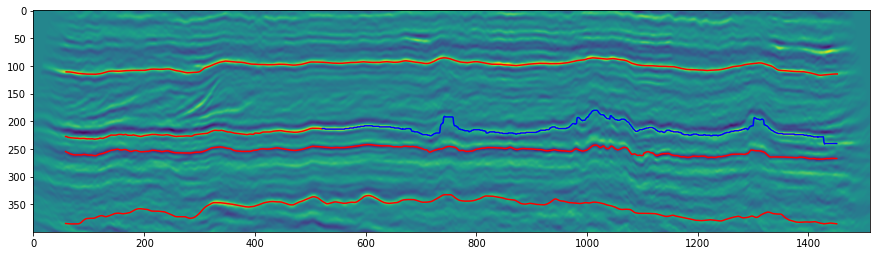

In [32]:
plt.imshow(all_data_l1.T[600:1000])
plt.plot(l1_horizons_train.hor_1-600, color='red')
plt.plot(l1_horizons_train.hor_2-600, color='red')

plt.plot(tmp.x.values, y_hat-600, color='blue')

plt.plot(l1_horizons_train.hor_3-600, color='red')
plt.plot(l1_horizons_train.hor_4-600, color='red')

In [500]:
def F(x, y, y_hat, heights):
    z = heights.T[y, x]
    z_hat = heights.T[y_hat, x]
    y = y / 3000
    y_hat = y_hat / 3000
    z = z / heights.max()
    z_hat = z_hat / heights.max()
    f = (y - y_hat)**2 + (z - z_hat)**2
    return f.sum() ** 1/2

In [501]:
F(tmp.x.values, tmp.hor_2.values.astype(int), y_hat2, all_data_l1)

IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 3001

In [21]:
my_submission.y = y_hat2

In [22]:
my_submission.to_csv("my_submission_evrstc21.csv", index=False)

In [284]:
int(0.6)

0